* [data.csv] : https://www.kaggle.com/carrie1/ecommerce-data

#Part5. [실습13] 소매 판매 데이터를 활용한 이커머스 고객 Segmentation 분석

## 01. 데이터 소개 및 분석프로세스 수립

## 02. 데이터 탐색 및 전처리

In [ ]:
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq

# from matplotlib import pyplot as plt
# import matplotlib.font_manager as fm

# path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
# font_name = fm.FontProperties(fname=path, size=10).get_name()

# plt.rc('font', family=font_name)

# fm._rebuild()

In [ ]:
from matplotlib import pyplot as plt
plt.rc('font', family='NanumBarunGothic')

* matplotlib 한글 깨짐 현상 해결
> 셀 실행 후 런타임 재시작 필요

### 0. 데이터 불러오기

In [ ]:
############################################## 00. 필요한 파이썬 라이브러리 불러오기 #####################################################
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
# import plotly.plotly as py
import plotly.graph_objs as go

from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [ ]:
df_init = pd.read_csv('/content/drive/MyDrive/강의/실습자료/data/ch15/data.csv',encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df_init.shape)

Dataframe dimensions: (541909, 8)


### 1. 데이터 준비

In [ ]:
df_init.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [ ]:
df_init.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID      object
Country         object
dtype: object

In [ ]:
df_init.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
df_init.shape[0]

541909

In [ ]:
# 날짜 데이터 변환
df_init['InvoiceDate'] = pd.to_datetime(df_init['InvoiceDate'])

# 데이터 타입 정보
col_info = pd.DataFrame(df_init.dtypes).T.rename(index={0:'column type'}) 
display(col_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object


#### 1) 컬럼별 데이터 타입 및 결측값 비율

In [ ]:
display(col_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object


In [ ]:
col_info = col_info.append(pd.DataFrame(df_init.isnull().sum()).T.rename(index={0:'null values (nb)'}))
display(col_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0


In [ ]:
col_info = col_info.append(pd.DataFrame(df_init.isnull().sum()/df_init.shape[0]*100).T.rename
                           (index={0:'null values (%)'}))
display(col_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


In [ ]:
display(df_init[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


#### 2) 결측값 처리

In [ ]:
df_init.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Shape:', df_init.shape)

Shape: (406829, 8)


In [ ]:
col_info = pd.DataFrame(df_init.dtypes).T.rename(index={0:'column type'})
col_info = col_info.append(pd.DataFrame(df_init.isnull().sum()).T.rename(index={0:'null values (nb)'}))

col_info = col_info.append(pd.DataFrame(df_init.isnull().sum()/df_init.shape[0]*100).T.
                           rename(index={0:'null values (%)'}))
display(col_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0


In [ ]:
df_init.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object

In [ ]:
df_init.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

#### 3) 중복값

In [ ]:
df_init['Country'].duplicated().value_counts()

True     406792
False        37
Name: Country, dtype: int64

In [ ]:
df_init['InvoiceNo'].duplicated().value_counts()

True     384639
False     22190
Name: InvoiceNo, dtype: int64

In [ ]:
print('Duplicate Entries: {}'.format(df_init.duplicated().sum()))
df_init.drop_duplicates(inplace = True)

Duplicate Entries: 5225


#### 4) 나라별 지도 시각화

In [ ]:
temp_cou = df_init[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()

In [ ]:
temp_cou

Empty DataFrame
Columns: []
Index: [(12346, 541431, United Kingdom), (12346, C541433, United Kingdom), (12347, 537626, Iceland), (12347, 542237, Iceland), (12347, 549222, Iceland), (12347, 556201, Iceland), (12347, 562032, Iceland), (12347, 573511, Iceland), (12347, 581180, Iceland), (12348, 539318, Finland), (12348, 541998, Finland), (12348, 548955, Finland), (12348, 568172, Finland), (12349, 577609, Italy), (12350, 543037, Norway), (12352, 544156, Norway), (12352, 545323, Norway), (12352, 545332, Norway), (12352, 546869, Norway), (12352, 547390, Norway), (12352, 567505, Norway), (12352, 568699, Norway), (12352, 574275, Norway), (12352, C545329, Norway), (12352, C545330, Norway), (12352, C547388, Norway), (12353, 553900, Bahrain), (12354, 550911, Spain), (12355, 552449, Bahrain), (12356, 541430, Portugal), (12356, 549435, Portugal), (12356, 576895, Portugal), (12357, 574740, Switzerland), (12358, 559707, Austria), (12358, 581232, Austria), (12359, 540946, Cyprus), (12359, 543370, Cyprus), (12359, 555477, Cyprus), (12359, 571034, Cyprus), (12359, C549955, Cyprus), (12359, C580165, Cyprus), (12360, 554132, Austria), (12360, 563749, Austria), (12360, 571705, Austria), (12361, 545017, Belgium), (12362, 544203, Belgium), (12362, 551346, Belgium), (12362, 559295, Belgium), (12362, 563037, Belgium), (12362, 568651, Belgium), (12362, 570667, Belgium), (12362, 572887, Belgium), (12362, 573173, Belgium), (12362, 574329, Belgium), (12362, 580979, Belgium), (12362, C544902, Belgium), (12362, C563752, Belgium), (12362, C579178, Belgium), (12363, 549687, Unspecified), (12363, 563947, Unspecified), (12364, 563854, Belgium), (12364, 567897, Belgium), (12364, 573401, Belgium), (12364, 580152, Belgium), (12365, 544574, Cyprus), (12365, 544578, Cyprus), (12365, C544577, Cyprus), (12367, 580716, Denmark), (12370, 538826, Cyprus), (12370, 539330, Austria), (12370, 546236, Cyprus), (12370, 571905, Cyprus), (12371, 570521, Switzerland), (12371, 572770, Switzerland), (12372, 544157, Denmark), (12372, 552731, Denmark), (12372, 568872, Denmark), (12373, 542887, Austria), (12374, 576345, Austria), (12375, 565333, Finland), (12375, 579281, Finland), (12375, C581071, Finland), (12377, 539488, Switzerland), (12377, 542586, Switzerland), (12378, 562046, Switzerland), (12379, 557789, Belgium), (12379, 567196, Belgium), (12379, C559193, Belgium), (12380, 555739, Belgium), (12380, 567928, Belgium), (12380, 571187, Belgium), (12380, 577180, Belgium), (12380, C572532, Belgium), (12381, 563100, Norway), (12381, 570681, Norway), (12381, 570725, Norway), (12381, 574694, Norway), (12381, 580638, Norway), (12381, C565050, Norway), (12383, 539840, Belgium), ...]

[22190 rows x 0 columns]

In [ ]:
temp_cou = temp_cou.reset_index(drop = False)

In [ ]:
temp_cou

,CustomerID,InvoiceNo,Country
0,12346,541431,United Kingdom
1,12346,C541433,United Kingdom
2,12347,537626,Iceland
3,12347,542237,Iceland
4,12347,549222,Iceland
...,...,...,...
22185,18283,579673,United Kingdom
22186,18283,580872,United Kingdom
22187,18287,554065,United Kingdom
22188,18287,570715,United Kingdom


In [ ]:
countries = temp_cou['Country'].value_counts()
print('No. of countries in the dataframe: {}'.format(len(countries)))

No. of countries in the dataframe: 37


Let's display the result on a chloropleth map

In [ ]:
countries.index

Index(['United Kingdom', 'Germany', 'France', 'EIRE', 'Belgium', 'Spain',
       'Netherlands', 'Switzerland', 'Portugal', 'Australia', 'Italy',
       'Finland', 'Sweden', 'Norway', 'Channel Islands', 'Japan', 'Poland',
       'Denmark', 'Cyprus', 'Austria', 'Singapore', 'Malta', 'Unspecified',
       'Iceland', 'USA', 'Greece', 'Israel', 'Canada', 'Czech Republic',
       'European Community', 'Lithuania', 'United Arab Emirates',
       'Saudi Arabia', 'Bahrain', 'Brazil', 'Lebanon', 'RSA'],
      dtype='object')

In [ ]:
countries

United Kingdom          19857
Germany                   603
France                    458
EIRE                      319
Belgium                   119
Spain                     105
Netherlands               101
Switzerland                71
Portugal                   70
Australia                  69
Italy                      55
Finland                    48
Sweden                     46
Norway                     40
Channel Islands            33
Japan                      28
Poland                     24
Denmark                    21
Cyprus                     20
Austria                    19
Singapore                  10
Malta                      10
Unspecified                 8
Iceland                     7
USA                         7
Greece                      6
Israel                      6
Canada                      6
Czech Republic              5
European Community          5
Lithuania                   4
United Arab Emirates        3
Saudi Arabia                2
Bahrain   

A `choropleth map` is a type of thematic map in which areas are shaded or patterned in proportion to a statistical variable that represents an aggregate summary of a geographic characteristic within each area, such as population density or per-capita income.

In [ ]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
pio.renderers
pio.renderers.default = 'colab'
pio.renderers

data = dict(type='choropleth', 
            locations = countries.index,
            locationmode = 'country names', z = countries,
            text = countries.index, colorbar = {'title':'Order no.'},
            colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
            reversescale = False)

In [ ]:
layout = dict(title='Number of orders per country',
              geo = dict(showframe = True, projection={'type':'mercator'}))

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

In [ ]:
df_init

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


> 각 항목별 데이터 개수

In [ ]:
len(df_init['CustomerID'].value_counts())

4372

In [ ]:
pd.DataFrame([{'products': len(df_init['StockCode'].value_counts()),    
               'transactions': len(df_init['InvoiceNo'].value_counts()),
               'customers': len(df_init['CustomerID'].value_counts()),}], 
             columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


> 고객 주문번호별 상품 개수

In [ ]:
temp_pro = df_init.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()

nb_products_per_basket = temp_pro.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


> 고객 주문번호별 주문 취소 여부와 주문 취소율

In [ ]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x)) 
display(nb_products_per_basket[:5])

n1 = nb_products_per_basket['order_canceled'].sum()

n2 = nb_products_per_basket.shape[0]

print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of orders canceled: 3654/22190 (16.47%) 


In [ ]:
display(df_init.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland


#### 5) 주문 취소된 항목 삭제한 새로운 컬럼 만들기

In [ ]:
df_cleaned = df_init.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = []
doubtfull_entry = []

for index, col in  df_init.iterrows():
    # 주문 수량이 0보다 크거나 할인의 경우
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': 
        continue        
    df_test = df_init[(df_init['CustomerID'] == col['CustomerID']) &
                         (df_init['StockCode']  == col['StockCode']) & 
                         (df_init['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_init['Quantity']   > 0)].copy()
    
    # 주문일이 더 빠르고 수량이 0보다 큰 경우가 1개도 없는 경우
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    
    # 주문일이 더 빠르고 수량이 0보다 큰 경우가 1개 있는 경우
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        # 취소된 수량에 대한 컬럼을 새로 생성한다.
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index) 
    
    # 주문일이 더 빠르고 수량이 0보다 큰 경우가 2개 이상인 경우
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)    

        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break 

In [ ]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 7521
doubtfull_entry: 1226


In [ ]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)

In [ ]:
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries.head(5)

nb of entries to delete: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754,United Kingdom,0


In [ ]:
remaining_entries.sort_index(axis=0)[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754,United Kingdom,0


In [ ]:
df_cleaned.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0


#### 6) StockCode 내 데이터 수정

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392857 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         392857 non-null  object        
 1   StockCode         392857 non-null  object        
 2   Description       392857 non-null  object        
 3   Quantity          392857 non-null  int64         
 4   InvoiceDate       392857 non-null  datetime64[ns]
 5   UnitPrice         392857 non-null  float64       
 6   CustomerID        392857 non-null  object        
 7   Country           392857 non-null  object        
 8   QuantityCanceled  392857 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 30.0+ MB


In [ ]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [ ]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


#### 7) 구매액 컬럼 생성

In [ ]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347,Iceland,0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347,Iceland,0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347,Iceland,0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347,Iceland,0,35.7


In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392857 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         392857 non-null  object        
 1   StockCode         392857 non-null  object        
 2   Description       392857 non-null  object        
 3   Quantity          392857 non-null  int64         
 4   InvoiceDate       392857 non-null  datetime64[ns]
 5   UnitPrice         392857 non-null  float64       
 6   CustomerID        392857 non-null  object        
 7   Country           392857 non-null  object        
 8   QuantityCanceled  392857 non-null  int64         
 9   TotalPrice        392857 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 33.0+ MB


#### 8) 주문일 컬럼 데이터타입 변경

In [ ]:
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
df_cleaned[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,InvoiceDate_int
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30,1291191960000000000
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,1291191960000000000
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00,1291191960000000000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,1291191960000000000
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34,1291191960000000000


#### 9) 고객 주문번호별 총 구매액/평균 주문시기 데이터 생성

In [ ]:
temp_sum = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp_sum.rename(columns = {'TotalPrice':'Basket Price'})

df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp_date = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp_date['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347,537626,711.79,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,2011-08-02 08:48:00.000000000
6,12347,573511,1294.32,2011-10-31 12:25:00.000001280


In [ ]:
basket_price.tail(6)

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
18626,18283,578262,307.05,2011-11-23 13:27:00.000002048
18627,18283,579673,220.31,2011-11-30 12:58:59.999998720
18628,18283,580872,208.00,2011-12-06 12:02:00.000001792
18629,18287,554065,765.28,2011-05-22 10:38:59.999998976
18630,18287,570715,1001.32,2011-10-12 10:22:59.999998720
18631,18287,573167,70.68,2011-10-28 09:29:00.000000000


In [ ]:
basket_price.max(), basket_price.min()

(CustomerID                    18287
 InvoiceNo                    581587
 Basket Price                  30757
 InvoiceDate     2011-12-09 12:50:00
 dtype: object, CustomerID                    12347
 InvoiceNo                    536365
 Basket Price                   0.38
 InvoiceDate     2010-12-01 08:26:00
 dtype: object)

#### 10) 키워드 생성

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df_products = pd.DataFrame(df_init['Description'].unique()).rename(columns = {0:'Description'})

In [ ]:
df_products

,Description
0,WHITE HANGING HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.
...,...
3891,"LETTER ""W"" BLING KEY RING"
3892,"LETTER ""Z"" BLING KEY RING"
3893,PINK CRYSTAL SKULL PHONE CHARM
3894,CREAM HANGING HEART T-LIGHT HOLDER


> 데이터 준비를 위한 자연어처리 내용 소개

In [ ]:
is_noun = lambda pos: pos[:2] == 'NN'

ex = "WHITE HANGING HEART T-LIGHT HOLDER"
lines = ex.lower()
tokenized = nltk.word_tokenize(lines)
nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 

In [ ]:
lines

'white hanging heart t-light holder'

In [ ]:
tokenized

['white', 'hanging', 'heart', 't-light', 'holder']

In [ ]:
# POS(part-of-speech)는 품사를 말한다.
nltk.pos_tag(tokenized)

[('white', 'JJ'),
 ('hanging', 'VBG'),
 ('heart', 'NN'),
 ('t-light', 'JJ'),
 ('holder', 'NN')]

In [ ]:
nouns

['heart', 'holder']

In [ ]:
# stemming : 어간(활용어에서 변하지 않는 부분)추출 - 어형이 변형된 단어로부터 접사 등을 제거하고 그 단어의 어간을 분리해 내는 것
stemmer = nltk.stem.SnowballStemmer("english")
print("The stemmed form of studying is: {}".format(stemmer.stem("studying")))
print("The stemmed form of studies is: {}".format(stemmer.stem("studies")))
print("The stemmed form of study is: {}".format(stemmer.stem("study")))

The stemmed form of studying is: studi
The stemmed form of studies is: studi
The stemmed form of study is: studi


In [ ]:
t = "heart"
racine = stemmer.stem(t)
racine

'heart'

In [ ]:

is_noun = lambda pos: pos[:2] == 'NN'
def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")

    keywords_roots  = dict()
    keywords_select = dict()
    category_keys   = []
    count_keywords  = dict()
    icount = 0

    # dataframe[colonne] : Description
    for s in dataframe[colonne]:
        if pd.isnull(s): 
            continue
        
        # Description 내 1개 데이터에 대해 소문자 처리
        lines = s.lower()

        # nltk 의 word_tokenize : 
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower()
            racine = stemmer.stem(t)

            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                # 어간을 key 로 tokenizing 해서 얻은 명사(NN)을 value 로 저장해 준다.
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
                
    for s in keywords_roots.keys():
        # 같은 어간을 가지는 것들이 2개 이상일 때
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k
                    min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
            
            
    print("'{}' 컬럼 안의 Keyword 수 : {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [ ]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)

'Description' 컬럼 안의 Keyword 수 : 1483


In [ ]:
keywords_select.items()

dict_items([('heart', 'heart'), ('holder', 'holder'), ('metal', 'metal'), ('lantern', 'lantern'), ('cream', 'cream'), ('cupid', 'cupid'), ('coat', 'coat'), ('hanger', 'hanger'), ('union', 'union'), ('flag', 'flag'), ('water', 'water'), ('bottl', 'bottle'), ('nest', 'nest'), ('box', 'box'), ('glass', 'glass'), ('star', 'star'), ('hand', 'hand'), ('jack', 'jack'), ('warmer', 'warmer'), ('dot', 'dot'), ('bird', 'bird'), ('ornament', 'ornament'), ('poppi', 'poppy'), ('playhous', 'playhouse'), ('bedroom', 'bedroom'), ('kitchen', 'kitchen'), ('feltcraft', 'feltcraft'), ('princess', 'princess'), ('charlott', 'charlotte'), ('doll', 'doll'), ('ivori', 'ivory'), ('cosi', 'cosy'), ('colour', 'colour'), ('teaspoon', 'teaspoons'), ('vintag', 'vintage'), ('jigsaw', 'jigsaw'), ('block', 'block'), ('alphabet', 'alphabet'), ('home', 'home'), ('build', 'building'), ('word', 'word'), ('love', 'love'), ('recip', 'recipe'), ('england', 'england'), ('jam', 'jam'), ('jar', 'jar'), ('rack', 'rack'), ('pari', 

In [ ]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

In [ ]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)

In [ ]:
liste

[['heart', 267],
 ['vintage', 211],
 ['set', 206],
 ['pink', 189],
 ['bag', 165],
 ['box', 155],
 ['glass', 149],
 ['christmas', 137],
 ['design', 128],
 ['candle', 121],
 ['holder', 120],
 ['flower', 120],
 ['decoration', 109],
 ['metal', 99],
 ['retrospot', 90],
 ['card', 90],
 ['necklac', 85],
 ['paper', 84],
 ['blue', 80],
 ['art', 75],
 ['silver', 72],
 ['cake', 70],
 ['polkadot', 68],
 ['cover', 68],
 ['mug', 66],
 ['tin', 66],
 ['wrap', 65],
 ['sign', 64],
 ['pack', 61],
 ['egg', 61],
 ['bracelet', 61],
 ['star', 59],
 ['bowl', 57],
 ['mini', 56],
 ['tea', 55],
 ['garden', 55],
 ['wall', 55],
 ['ivory', 54],
 ['cushion', 54],
 ['frame', 52],
 ['mirror', 50],
 ['cream', 49],
 ['home', 49],
 ['gift', 49],
 ['earrings', 49],
 ['ring', 46],
 ['bird', 45],
 ['bottle', 44],
 ['clock', 44],
 ['paisley', 42],
 ['letter', 42],
 ['party', 42],
 ['charm', 41],
 ['wood', 40],
 ['ribbon', 40],
 ['jar', 39],
 ['garland', 39],
 ['hook', 39],
 ['gold', 39],
 ['easter', 39],
 ['bead', 38],
 ['dr

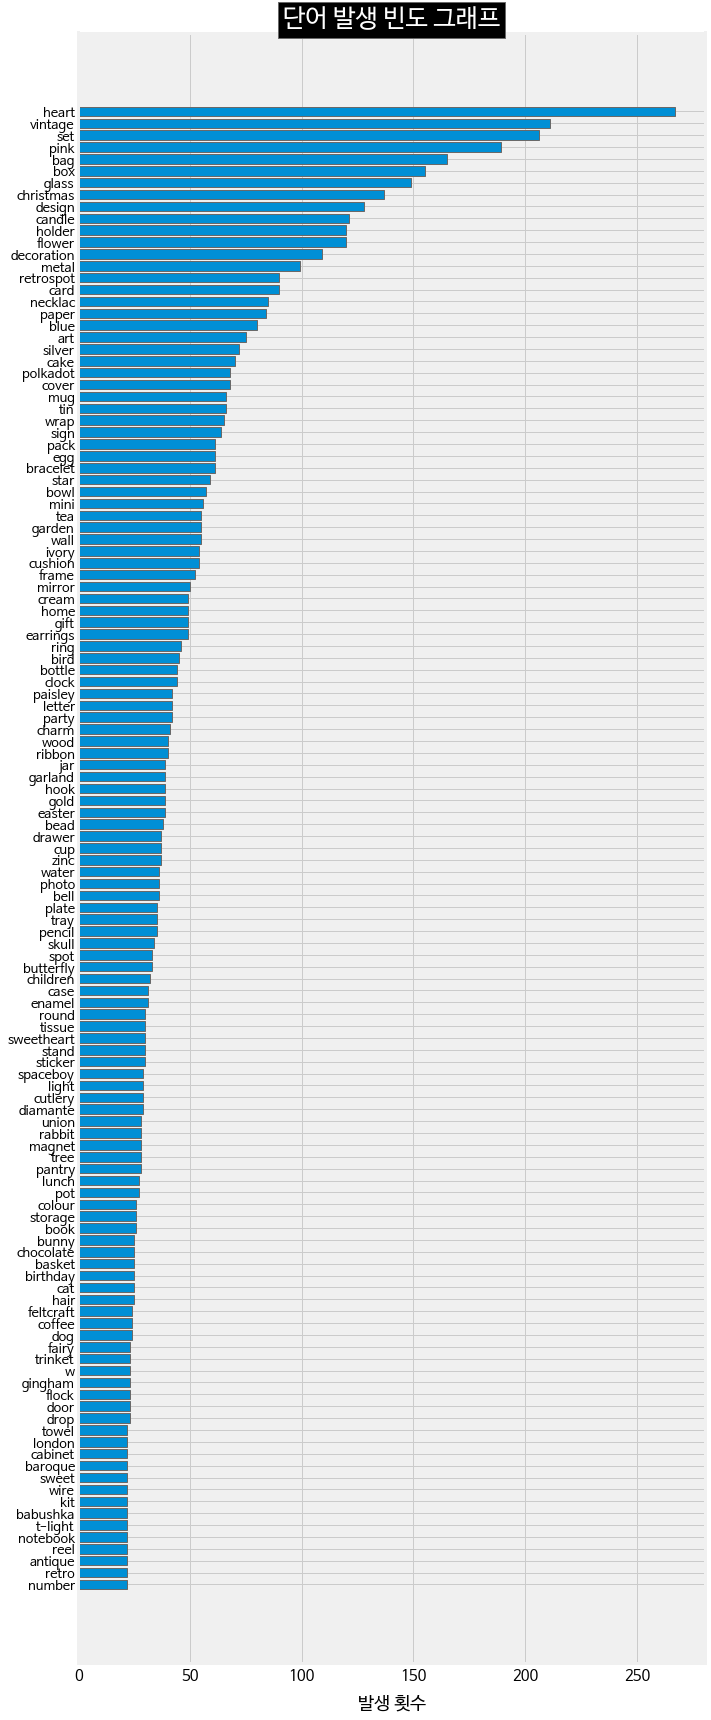

In [ ]:
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(10, 30))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("발생 횟수", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()


plt.title("단어 발생 빈도 그래프",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

In [ ]:
count_keywords

{'heart': 267,
 'holder': 120,
 'metal': 99,
 'lantern': 8,
 'cream': 49,
 'cupid': 2,
 'coat': 7,
 'hanger': 19,
 'union': 28,
 'flag': 12,
 'water': 36,
 'bottl': 44,
 'nest': 3,
 'box': 155,
 'glass': 149,
 'star': 59,
 'hand': 20,
 'jack': 21,
 'warmer': 17,
 'dot': 3,
 'bird': 45,
 'ornament': 1,
 'poppi': 7,
 'playhous': 4,
 'bedroom': 1,
 'kitchen': 20,
 'feltcraft': 24,
 'princess': 3,
 'charlott': 11,
 'doll': 11,
 'ivori': 54,
 'cosi': 6,
 'colour': 26,
 'teaspoon': 1,
 'vintag': 211,
 'jigsaw': 15,
 'block': 9,
 'alphabet': 13,
 'home': 49,
 'build': 3,
 'word': 3,
 'love': 9,
 'recip': 6,
 'england': 4,
 'jam': 18,
 'jar': 39,
 'rack': 15,
 'pari': 5,
 'fashion': 3,
 'bath': 8,
 'alarm': 7,
 'clock': 44,
 'bakelik': 4,
 'pink': 189,
 'green': 14,
 'panda': 1,
 'bunni': 25,
 'sheet': 8,
 'tape': 18,
 'globe': 1,
 'head': 3,
 'tail': 4,
 'game': 6,
 'set/2': 1,
 'retrospot': 90,
 'tea': 55,
 'towel': 22,
 'round': 30,
 'snack': 9,
 'woodland': 21,
 'spaceboy': 29,
 'lunch': 2

In [ ]:
liste_products = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_products))

In [ ]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []

for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_products):
    prix = df_cleaned[df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

### 2. K-Means Clustering 과 PCA

#### 1) Silhouette Score 기반 K

In [ ]:
X.head()

,heart,vintage,set,pink,bag,box,glass,christmas,design,candle,holder,flower,decoration,metal,retrospot,card,necklac,paper,blue,art,silver,cake,polkadot,cover,mug,tin,wrap,sign,pack,egg,bracelet,star,bowl,mini,tea,garden,wall,ivory,cushion,frame,...,modern,work,feeding,station,safety,metre,carrier,helga,heidi,resolution,bridge,oxford,baker,hill,town,miror,decrotivevintage,pick,naughts,blueberry,fondant,chrome,sil't,squ,crome,candle+incense,czech,puncture,country,f,o,t,z,birdie,0<.<1,1<.<2,2<.<3,3<.<5,5<.<10,.>10
0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0


In [ ]:
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(X)
    clusters = kmeans.predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    print("클러스터 개수 =", n_clusters, "silhouette 평균 점수 :", silhouette_avg)

클러스터 개수 = 3 silhouette 평균 점수 : 0.03240195466062184
클러스터 개수 = 4 silhouette 평균 점수 : 0.038376128876451664
클러스터 개수 = 5 silhouette 평균 점수 : 0.037164755776056234
클러스터 개수 = 6 silhouette 평균 점수 : 0.04020932253056911
클러스터 개수 = 7 silhouette 평균 점수 : 0.043115927104288264
클러스터 개수 = 8 silhouette 평균 점수 : 0.0415451832999826
클러스터 개수 = 9 silhouette 평균 점수 : 0.043646056656327495


In [ ]:
n_clusters = 5

kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(X)
clusters = kmeans.predict(X)

In [ ]:
pd.Series(clusters).value_counts()

0    1476
2    1143
4     745
1     297
3     217
dtype: int64

#### 2) PCA

In [ ]:
pca = PCA()
pca.fit(X)
pca_samples = pca.transform(X)

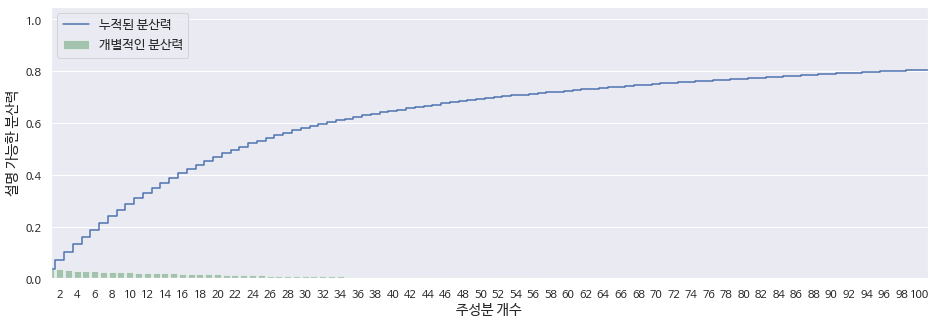

In [ ]:

fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)

plt.rc('font', family='NanumBarunGothic')
plt.step(range(X.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='누적된 분산력')

sns.barplot(np.arange(1,X.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='개별적인 분산력')

plt.xlim(0, 100)


ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('설명 가능한 분산력', fontsize = 14)
plt.xlabel('주성분 개수', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

In [ ]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(X)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

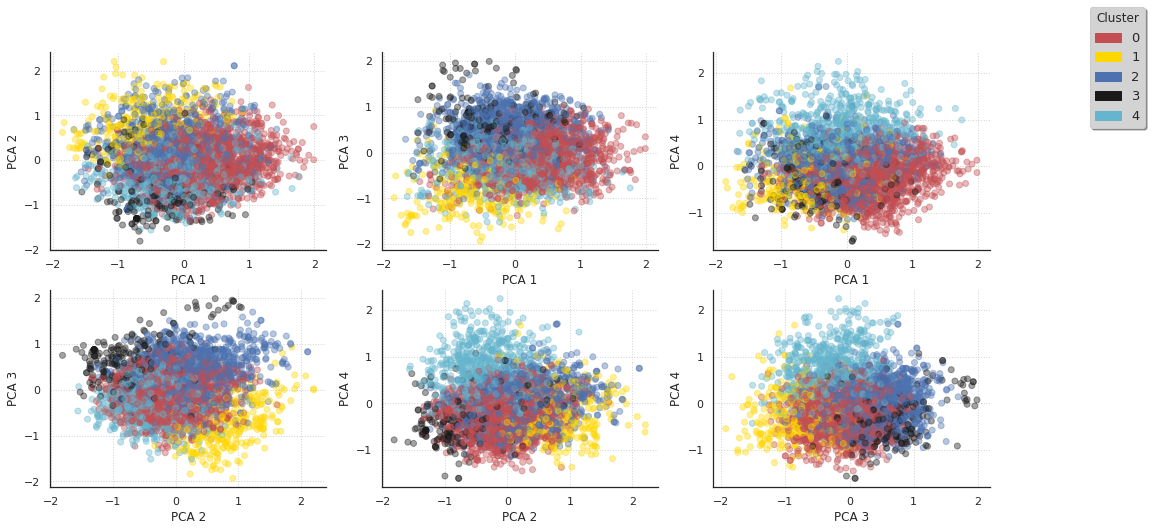

In [ ]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

In [ ]:
corresp = dict()
for key, val in zip (liste_products, clusters):
    corresp[key] = val 

df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

In [ ]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
    

df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,1,0.0,15.30,0.00,0.0,0.00
1,536365,WHITE METAL LANTERN,2,0.0,0.00,20.34,0.0,0.00
2,536365,CREAM CUPID HEARTS COAT HANGER,1,0.0,22.00,0.00,0.0,0.00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,4,0.0,0.00,0.00,0.0,20.34
4,536365,RED WOOLLY HOTTIE WHITE HEART.,1,0.0,20.34,0.00,0.0,0.00


In [ ]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp

df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]    

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347,537626,711.79,230.25,19.80,68.1,57.4,336.24,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,205.75,28.44,38.9,51.0,151.30,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,209.25,30.00,255.6,123.4,18.00,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,119.62,20.40,23.8,51.0,167.70,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,203.21,39.60,38.7,145.2,158.20,2011-08-02 08:48:00.000000000


In [ ]:
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [ ]:
# number of visits and stats on the basket amount / users
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,7,224.82,1294.32,615.714286,4310.00,37.284919,5.177262,14.484455,14.199536,28.853828
1,12348,4,227.44,892.80,449.310000,1797.24,61.756916,9.534620,21.900247,3.538759,3.269458
2,12349,1,1757.55,1757.55,1757.550000,1757.55,39.016813,13.430628,31.806776,5.774516,9.971267
3,12350,1,334.40,334.40,334.400000,334.40,33.761962,0.000000,19.766746,5.921053,40.550239
4,12352,7,144.35,840.30,340.815714,2385.71,40.528815,3.931744,45.557088,2.242519,7.739834


In [ ]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347,7,224.82,1294.32,615.714286,4310.00,37.284919,5.177262,14.484455,14.199536,28.853828,2,367
1,12348,4,227.44,892.80,449.310000,1797.24,61.756916,9.534620,21.900247,3.538759,3.269458,75,358
2,12349,1,1757.55,1757.55,1757.550000,1757.55,39.016813,13.430628,31.806776,5.774516,9.971267,18,18
3,12350,1,334.40,334.40,334.400000,334.40,33.761962,0.000000,19.766746,5.921053,40.550239,310,310
4,12352,7,144.35,840.30,340.815714,2385.71,40.528815,3.931744,45.557088,2.242519,7.739834,36,296


In [ ]:
n1_check = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n1_check

1489

In [ ]:
n2_check = transactions_per_user.shape[0]
n2_check

4327

In [ ]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("no. of customers with single purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

no. of customers with single purchase: 1489/4327  (34.41%)


In [ ]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']

#
selected_customers = transactions_per_user.copy(deep = True)
X_selected = selected_customers[list_cols]

In [ ]:
X_selected

,count,min,max,mean,categ_0,categ_1,categ_2,categ_3,categ_4
0,7,224.82,1294.32,615.714286,37.284919,5.177262,14.484455,14.199536,28.853828
1,4,227.44,892.80,449.310000,61.756916,9.534620,21.900247,3.538759,3.269458
2,1,1757.55,1757.55,1757.550000,39.016813,13.430628,31.806776,5.774516,9.971267
3,1,334.40,334.40,334.400000,33.761962,0.000000,19.766746,5.921053,40.550239
4,7,144.35,840.30,340.815714,40.528815,3.931744,45.557088,2.242519,7.739834
...,...,...,...,...,...,...,...,...,...
4322,1,180.60,180.60,180.600000,19.684385,0.000000,31.339978,8.222591,40.753045
4323,1,80.82,80.82,80.820000,81.069042,0.000000,18.930958,0.000000,0.000000
4324,2,77.84,98.76,88.300000,40.922990,0.000000,28.414496,10.022650,20.639864
4325,16,1.95,307.05,127.845625,37.321379,2.895093,36.349015,13.826734,9.607779


In [ ]:
scaler = StandardScaler()
scaler.fit(X_selected)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_X_selected = scaler.transform(X_selected)

variables mean values: 
------------------------------------------------------------------------------------------
 [  4.25190663 241.38253571 578.87676959 372.25705475  37.76807678
  10.25463738  30.52092764   6.62355806  14.84060126]


In [ ]:
scaled_X_selected

array([[ 0.36008454, -0.05183927,  0.62938613, ..., -0.91779733,
         0.78525848,  0.93883103],
       [-0.0330075 , -0.0436389 ,  0.27616297, ..., -0.49337767,
        -0.31974278, -0.77522106],
       [-0.42609954,  4.74547007,  1.03689651, ...,  0.07359153,
        -0.08800418, -0.32622623],
       ...,
       [-0.29506886, -0.51187367, -0.42236592, ..., -0.12055502,
         0.35231964,  0.38852778],
       [ 1.53936067, -0.74940266, -0.23913008, ...,  0.33355232,
         0.74661718, -0.35057849],
       [-0.16403818, -0.53428384,  0.37162964, ...,  1.17450776,
        -0.58092926, -0.72077579]])

In [ ]:
pca = PCA()
pca.fit(scaled_X_selected)
pca_samples = pca.transform(scaled_X_selected)

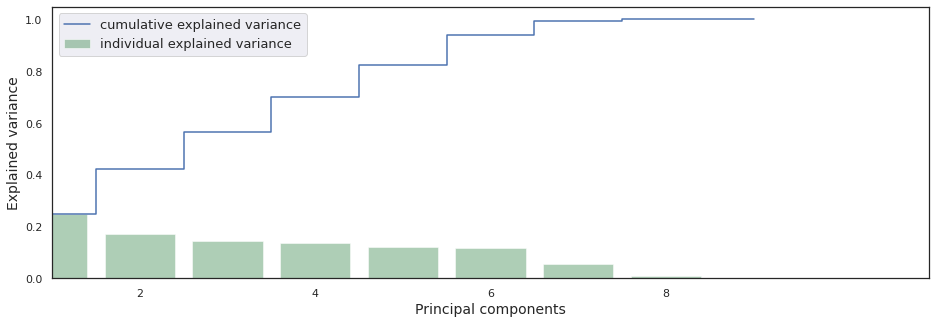

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(X_selected.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,X_selected.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

In [ ]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_X_selected)
clusters_clients = kmeans.predict(scaled_X_selected)
silhouette_avg = silhouette_score(scaled_X_selected, clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.217


In [ ]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['no. of customers']).T

,4,10,1,6,7,5,0,3,9,2,8
no. of customers,1816,806,498,359,220,216,197,179,17,12,7


In [ ]:
pca = PCA(n_components=6)
X_selected_3D = pca.fit_transform(scaled_X_selected)
mat = pd.DataFrame(X_selected_3D)
mat['cluster'] = pd.Series(clusters_clients)

In [ ]:
mat.head()

,0,1,2,3,4,5,cluster
0,0.659859,-0.496212,1.011481,-0.218565,1.052897,0.639735,4
1,0.363947,-1.256065,-0.314143,0.283176,-0.743742,-0.031875,10
2,4.806572,0.394148,-0.772257,-2.557896,-0.729862,-0.262563,0
3,-0.264142,-0.300998,0.909583,-1.171483,1.270774,-0.588538,7
4,0.122830,0.169617,-0.410512,0.965214,-0.068568,-0.739251,4


#### 3) 시각화

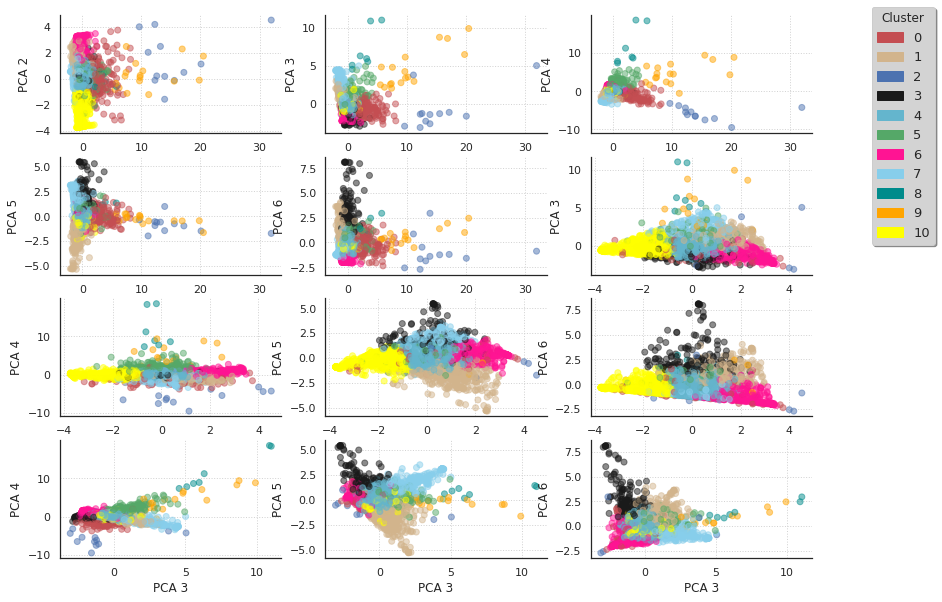

In [ ]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

In [ ]:
selected_customers.loc[:, 'cluster'] = clusters_clients

### 3. 고객군 분류 예측 모델링

In [ ]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()
            
    # train on the x_train and y_train data
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    # predict/validate on the held-out data
    def predict(self, x):
        return self.clf.predict(x)
    
    # hyperparameter tuning using GridsearchCV
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
    
    # fit after tuning
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
    
    # predict
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

In [ ]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

In [ ]:
Y.value_counts()

4     1816
10     806
1      498
6      359
7      220
5      216
0      197
3      179
9       17
2       12
8        7
Name: cluster, dtype: int64

In [ ]:
X.head()

,mean,categ_0,categ_1,categ_2,categ_3,categ_4
0,615.714286,37.284919,5.177262,14.484455,14.199536,28.853828
1,449.310000,61.756916,9.534620,21.900247,3.538759,3.269458
2,1757.550000,39.016813,13.430628,31.806776,5.774516,9.971267
3,334.400000,33.761962,0.000000,19.766746,5.921053,40.550239
4,340.815714,40.528815,3.931744,45.557088,2.242519,7.739834


In [ ]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8, random_state=0)

In [ ]:
X_train.shape, Y_train.shape

((3461, 6), (3461,))

In [ ]:
X_test.shape, Y_test.shape

((866, 6), (866,))

In [ ]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

In [ ]:
svc.grid_fit(X = X_train, Y = Y_train)

In [ ]:
svc.grid_predict(X_test, Y_test)

Precision: 90.18 % 


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


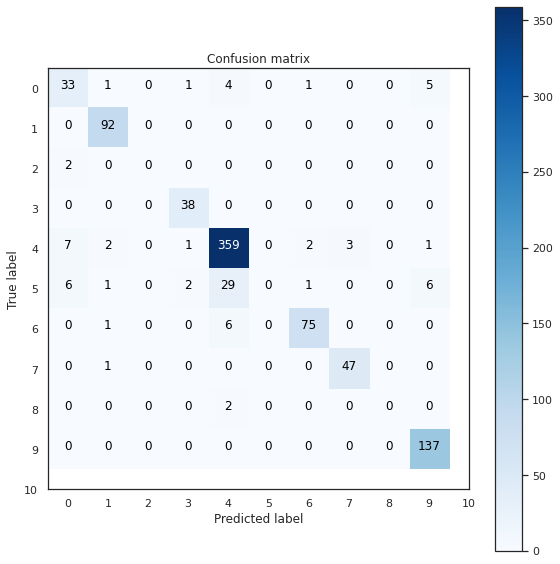

In [ ]:
class_names = [i for i in range(11)]

cnf_matrix = confusion_matrix(Y_test, svc.predictions) 

np.set_printoptions(precision=2)

plt.figure(figsize = (8,8))

plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

In [ ]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)

# fit on training data
lr.grid_fit(X = X_train, Y = Y_train)

# predict on test data
lr.grid_predict(X_test, Y_test)

Precision: 89.26 % 


#### k-Nearest Neighbors

In [ ]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)

# fit on training data
knn.grid_fit(X = X_train, Y = Y_train)

# predict on test data
knn.grid_predict(X_test, Y_test)

Precision: 81.87 % 


#### Decision Tree

In [ ]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)

# fit on training data
tr.grid_fit(X = X_train, Y = Y_train)

# predict on test data
tr.grid_predict(X_test, Y_test)

Precision: 85.10 % 


#### Random Forest

In [ ]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}

rf.grid_search(parameters = param_grid, Kfold = 5)

# fit on training data
rf.grid_fit(X = X_train, Y = Y_train)

# predict on test data
rf.grid_predict(X_test, Y_test)

Precision: 90.07 % 


#### AdaBoost Classifier

In [ ]:
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)

# fit on training data
ada.grid_fit(X = X_train, Y = Y_train)

# predict on test data
ada.grid_predict(X_test, Y_test)

Precision: 59.01 % 


#### Gradient Boosting Classifier

In [ ]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)

# fit on training data
gb.grid_fit(X = X_train, Y = Y_train)

# predict on test data
gb.grid_predict(X_test, Y_test)

Precision: 89.49 % 


#### Voting Classifier

In [ ]:
# random forest classifier best params
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)

# gradient boosting classifier best params
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)

# support vector classifier best params
svc_best = svm.LinearSVC(**svc.grid.best_params_)

# decision tree classifier best params
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)

# k-nearest neighbor classifier best params
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)

# logistics regression best params
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

In [ ]:
###### 코드 작성 부분 시작 ######
# rf_best, gb_best, lr_best 애 대한 Voting Ensemble, voting='soft'
# votingC =
###### 코드 작성 부분 마침 ######
votingC = votingC.fit(X_train, Y_train)
predictions = votingC.predict(X_test)

print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 90.30 % 
